# Milestone Project 1: 🍔👁 Food Vision Big™

Objective:  beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training


## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard



## Check GPU

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

If we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance is compataible. 

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+. 

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training**.

Therefore before we proceed we need to make sure we have **access to a Tesla T4 GPU in our Google Colab instance**.

> 🔑 **Note:** If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f8561ffe-a314-cde6-adb1-a76de3898057)


Since mixed precision training was introduced in TensorFlow 2.4.0, make sure you've got at least TensorFlow 2.4.0+.

In [2]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.2


## Get helper functions

Import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [3]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-15 00:23:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 00:23:57 (69.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [12]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True



To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters:

* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteIK3YNV/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteIK3YNV/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.




Now let's get a little information from our dataset, starting with the class names.

* Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

* We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [13]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [14]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [15]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).


In [16]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 32,  14,   0],
        [ 31,  13,   0],
        [ 28,  12,   0],
        ...,
        [ 54,  34,  10],
        [ 53,  33,   9],
        [ 51,  31,   7]],

       [[ 28,  10,   0],
        [ 28,  10,   0],
        [ 27,  11,   0],
        ...,
        [ 56,  36,  12],
        [ 55,  35,  11],
        [ 54,  34,   9]],

       [[ 30,  12,   0],
        [ 31,  13,   0],
        [ 31,  15,   0],
        ...,
        [ 58,  38,  13],
        [ 58,  38,  13],
        [ 58,  38,  11]],

       ...,

       [[135,  80,   0],
        [136,  81,   1],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[137,  82,   2],
        [137,  82,   2],
        [137,  82,   2],
        ...,
        [ 13,   6,   0],
        [ 13,   6,   0],
        [ 13,   6,   0]],

       [[136,  81,   1],
        [135,  80,   0],
        [135,  80,   0],
        ...,
        [ 14,   7,   

In [17]:
# min and max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

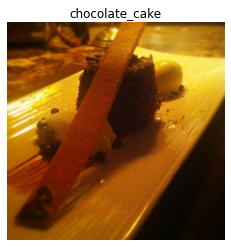

In [18]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.preprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [9]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  #image = image/255 #scale image values (not rquired for EfficientNetBX models)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[32 14  0]
  [31 13  0]
  [28 12  0]
  ...
  [54 34 10]
  [53 33  9]
  [51 31  7]]

 [[28 10  0]
  [28 10  0]
  [27 11  0]
  ...
  [56 36 12]
  [55 35 11]
  [54 34  9]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[29.19898    11.198979    0.        ]
  [28.285715   12.285714    0.        ]
  [30.852041   15.494898    0.28061217]
  ...
  [52.9336     32.505074    8.7193365 ]
  [54.025528   34.025528   10.025528  ]
  [53.800972   33.800972    9.571359  ]]

 [[33.09694    15.096939    1.193878  ]
  [33.785713   17.785715    2.785715  ]
  [31.785713   16.428572    1.2142859 ]
  ...
  [63.60206    42.530632   15.346998  ]
  [61.647934   40.7857     13.928558  ]
  [60.785713   41.714287   12.020403  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.



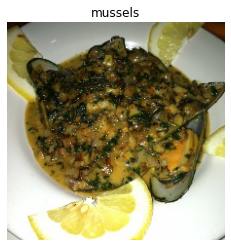

In [ ]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

* We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [20]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, 
                            num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, 
                          num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).


## Create modelling callbacks

We'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [22]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Setup mixed precision training

When using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

* Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

The [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started. First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

> As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [24]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

## Build feature extraction model

To build the feature extraction model we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Import the base model --> EfficientNetB0
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

16719872/16705208 [==============================] - 0s 0us/step


In [26]:
#create instance of model 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)


In [28]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [29]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:5]: # only check the first 5 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">


> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model

Order of Transfer Learning process:
1. Build a feature extraction model (train a few output layers with base layers frozen)
2. Fine-tune a small subset of frozen layers at a time 

In [30]:
# Fit the model with callbacks
initial_epochs = 3
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=initial_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220815-004042
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8216 - accuracy: 0.5585

2368/2368 [==============================] - 216s 83ms/step - loss: 1.8216 - accuracy: 0.5585 - val_loss: 1.2428 - val_accuracy: 0.6713
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2941 - accuracy: 0.6673

2368/2368 [==============================] - 183s 77ms/step - loss: 1.2941 - accuracy: 0.6673 - val_loss: 1.1195 - val_accuracy: 0.6949
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1440 - accuracy: 0.7016

2368/2368 [==============================] - 205s 86ms/step - loss: 1.1440 - accuracy: 0.7016 - val_loss: 1.0763 - val_accuracy: 0.7082


In [31]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 64ms/step - loss: 1.0888 - accuracy: 0.7074


[1.0888155698776245, 0.7073663473129272]

## TODO: Save the whole model to file

In [32]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save_weights(checkpoint_path)

In [33]:
# Load model previously saved above
model.load_weights(checkpoint_path)

In [42]:
# Check the layers in the base model and see what dtype policy they're using
layers = model.layers

for layer in layers:
  print(f"Layer:{layer.name} {layer.dtype_policy}")

Layer:input_layer <Policy "float32">
Layer:efficientnetb0 <Policy "mixed_float16">
Layer:pooling_layer <Policy "mixed_float16">
Layer:dense <Policy "mixed_float16">
Layer:softmax_float32 <Policy "float32">


In [44]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
loaded_weights_model_results = model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.0888 - accuracy: 0.7074


In [45]:
results_feature_extract_model == loaded_weights_model_results

False

In [46]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
np.isclose(np.array(results_feature_extract_model), np.array(loaded_weights_model_results))

array([ True,  True])

## TODO: Preparing our model's layers for fine-tuning

**Next:** Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [47]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-08-15 01:17:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  48.0MB/s    in 0.3s    

2022-08-15 01:17:15 (48.0 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [48]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [49]:
# Load and evaluate downloaded GS model
gs_model_path = "/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision"
gs_model = tf.keras.models.load_model(gs_model_path)


NameError: ignored

In [ ]:
# Get a summary of the downloaded model
gs_model.summary()

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
gs_model_results = gs_model.evaluate(test_data)
gs_model_results

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)

# Unfreeze all of the layers in the base model
gs_model.trainable = True

In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
gs_layers = gs_model.layers

for layer in gs_layers:
  print(f"Layer:{layer.name} {layer.dtype_policy}")

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE
checkpoint_filepath = 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                save_best_only=True)

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning

# Recompile model with lower learning rate
gs_model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
                 metrics=['accuracy'])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE
# Fine-tune for 5 more epochs
fine_tune_epochs = 100 

history_101_food_classes_fine_tune = model.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                               callbacks=[early_stop_callback, 
                                                          model_checkpoint_callback,
                                                          reduce_lr,
                                                          create_tensorboard_callback("training_logs", 
                                                                                      "efficientnetb0_101_classes_all_data_feature_extract")]) 

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
gs_model.save(gs_model_path)

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_gs_model_fine_tuned = gs_model.evaluate(test_data) 
results_gs_model_fine_tuned

## TODO: View training results on TensorBoard

**To do:** Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.


In [ ]:
# YOUR_CODE_HERE

## TODO: Evaluate your trained model

Some ideas you might want to go through:
1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's *most wrong* predictions (those with the highest prediction probability but the wrong prediction).

See the evaluation section at the end of [Transfer Learning Part 3: Scaling Up for more](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb).

In [ ]:
# YOUR_CODE_HERE